In [1]:
######################
## General packages ##
######################

import os
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
#################################
## Load visualization packages ##
#################################

from covid19model.visualization.output import color_timeframes
from covid19model.visualization.output import color_timeframes
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.models.utils import output_to_visuals, add_negative_binomial

## National model

In [3]:
################################
## Define simulation settings ##
################################

# Number of simulations for structural uncertainty
N = 18
# Number of negative binomial draws on each simulation
K = 10
# Number of cores to use for the simulations
processes = 18
# End of simulation
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05

In [4]:
##################################
## Import the necessary modules ##
##################################

from covid19model.data import sciensano
from covid19model.models.utils import load_samples_dict
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'national'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'national_two_effectivities_SAMPLES_2023-02-23.json'

##############################
## Define results locations ##
##############################

# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIQRD/'+agg+'/others/WAVE1/'

#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples were saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/'+agg+'/'
samples_dict_nat = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict_nat['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_nat['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_nat['end_calibration']

##################################################
## Load data not needed to initialize the model ##
##################################################

# Hospitalization data
public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data(update=False)[0]['H_in']
# Serodata
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model_nat, base_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                        update_data=False, start_date=start_calibration,
                                                                        stochastic=True)

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fnc_national

## Arrondissement spatial model

In [5]:
##################################
## Import the necessary modules ##
##################################

from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'arr'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'arr_summer_mentality_SAMPLES_2023-03-02.json'
        
#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/'+agg+'/'
samples_dict_arr = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict_arr['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_arr['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_arr['end_calibration']

##########################
## Initialize the model ##
##########################

model_arr, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)
#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_spatial_hybrid_vacc as draw_fnc_spatial

## Provincial spatial model

In [6]:
################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'prov'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'prov_summer_mentality_SAMPLES_2023-03-01.json'

#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/'+agg+'/'
samples_dict_prov = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict_prov['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_prov['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_prov['end_calibration']

##########################
## Initialize the model ##
##########################

model_prov, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)

In [ ]:
########################
## Simulate scenarios ##
########################

print('\nNational model\n')

out_nat = []
start_relaxations=['2021-03-01','2021-04-01','2021-05-01','2021-06-01']
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_nat.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_nat.sim([start_calibration,end_sim], N=N, tau=1/2, processes=processes,
                         draw_function=draw_fnc_national,samples=samples_dict_nat)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_nat.append(tmp_out)


National model

	Currently at relaxation date: 2021-03-01

	Currently at relaxation date: 2021-04-01

	Currently at relaxation date: 2021-05-01

	Currently at relaxation date: 2021-06-01



In [ ]:
out_prov = []
print('\nProvincial model\n')
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_prov.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_prov.sim([start_calibration,end_sim], N=N, tau=3/4, processes=processes,
                         draw_function=draw_fnc_spatial,samples=samples_dict_prov)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_prov.append(tmp_out)

In [ ]:
########################
## Simulate scenarios ##
########################

print('\nArrondissement model\n')
out_arr = []
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_arr.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_arr.sim([start_calibration,end_sim], N=N, tau=3/4, processes=processes,
                         draw_function=draw_fnc_spatial,samples=samples_dict_arr)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_arr.append(tmp_out)    

## Compute contacts

In [7]:
start_visualization = '2020-09-01'
end_visualization = '2021-09-01'

In [8]:
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import  make_contact_matrix_function
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, model_parameters
df_google = mobility.get_google_mobility_data(update=False, provincial=True)
Nc_dict, params, samples_dict, initN = model_parameters.get_COVID19_SEIQRD_parameters(agg='prov')
policy_function_scenarios = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial_manuscript
policy_function_normal = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial

In [10]:
start_relaxations=['2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01']
dates = pd.date_range(start=start_visualization, end=end_visualization)
contacts=[]
hosp = public_spatial_hosp_df.groupby(by='date').sum()
for start_relaxation in start_relaxations:
    c=[]
    for date in dates:
        c.append(np.mean(np.sum(policy_function_scenarios(date ,{'H_in': hosp[date]}, {},
                                model_prov.parameters['l1'],
                                model_prov.parameters['l2'],                     
                                np.mean(samples_dict_arr['eff_work']),
                                np.mean(samples_dict_arr['eff_work']),
                                np.mean(samples_dict_arr['eff_rest']),  
                                model_prov.parameters['eff_home'],                         
                                np.mean(samples_dict_arr['mentality']),
                                np.mean(samples_dict_arr['k']),  
                                np.mean(samples_dict_arr['summer_rescaling_F']), 
                                np.mean(samples_dict_arr['summer_rescaling_W']),                           
                                start_relaxation),axis=1)))
    contacts.append(pd.Series(index=dates, data=c))
    
c=[]
for date in dates:
    c.append(np.mean(np.sum(policy_function_normal(date ,{'H_in': hosp[date]}, {},
                                model_prov.parameters['l1'],
                                model_prov.parameters['l2'],                     
                                np.mean(samples_dict_arr['eff_work']),
                                np.mean(samples_dict_arr['eff_work']),
                                np.mean(samples_dict_arr['eff_rest']),  
                                model_prov.parameters['eff_home'],                         
                                np.mean(samples_dict_arr['mentality']),
                                np.mean(samples_dict_arr['k']),  
                                np.mean(samples_dict_arr['summer_rescaling_F']), 
                                np.mean(samples_dict_arr['summer_rescaling_W'])),axis=1)))    
contacts_normal = pd.Series(index=dates, data=c)

## Visualize results

In [ ]:
#######################
## Visualize results ##
#######################

start_visualization = '2020-09-01'
end_visualization = '2021-09-01'
start_scenarios = '2021-03-01'

scenario_linestyles=['-','--','-.',':']
legend_text=['S0', 'S1', 'S2', 'S3']
scatter_size = 10
alpha_scatter = 1
# Model prediction properties
linewidth=0.5
alpha_structural=0.20
scenario_colors = ['maroon', 'blue', 'olive', 'black']
# Data
y_data = public_spatial_hosp_df.groupby(by='date').sum()[:start_scenarios]
x_data = y_data.index

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,8), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)

output = [out_arr, out_prov, out_nat]
for k,out in enumerate(output):
    
    x_model = out[0].date.values

    #########################
    ## Loop over scenarios ##
    #########################

    for i in range(len(start_relaxations)):
        ax[k].plot(out[i]['H_in'].mean(dim='draws').sel(date=slice(start_scenarios, None))['date'].values,
                    out[i]['H_in'].mean(dim='draws').sel(date=slice(start_scenarios, None)), color=scenario_colors[i],
                    alpha=1, linestyle=scenario_linestyles[i])
        if k == 0:
            ax[k].legend(legend_text, loc=9, ncol=2, framealpha=1)

    for i in range(len(start_relaxations)):
        for j in range(1,N):
            ax[k].plot(out[i]['H_in'].isel(draws=j).sel(date=slice(start_scenarios, None))['date'].values,
                    out[i]['H_in'].isel(draws=j).sel(date=slice(start_scenarios, None)), color=scenario_colors[i],
                    linewidth=linewidth, alpha=alpha_structural)

    ################################################
    ## Plot one model prediction until March 30th ##
    ################################################

    for i in range(N):
        ax[k].plot(out[0]['H_in'].isel(draws=i).sel(date=slice(None, start_scenarios))['date'].values,
                out[0]['H_in'].isel(draws=i).sel(date=slice(None, start_scenarios)), color='black',
                linewidth=linewidth, alpha=alpha_structural)

    ########################
    ## Plot national data ##
    ########################

    ax[k].scatter(x_data, y_data, s=scatter_size, color='k', marker='x', linewidth=1, alpha=alpha_scatter)

    ########################
    ## Plot vertical line ##
    ########################

    ax[k].axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

    
    ################
    ## Background ##
    ################

    start_background = pd.Timestamp(2020, 1, 1)
    week_color='blanchedalmond'#'white'
    weekend_color='blanchedalmond'#'lightgrey'
    vacation_color='khaki'#weekend_color
    color_timeframes(start_background, end_sim, ax=ax[k], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

    ###################
    ## Format figure ##
    ###################

    ax[k].set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
    ax[k].set_ylim([0, 1100])
    ax[k].grid(False)
    ax[k].set_ylabel('Daily Hospitalizations', fontsize=12)
    
    ##############
    ## Text box ##
    ##############

    titles = ['Arrondissement model\n(nationally aggregated)', 'Provincial model\n(nationally aggregated)', 'National model']   
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in upper left in axes coords
    ax[k].text(0.01, 0.90, titles[k], transform=ax[k].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

###################
## Plot contacts ##
###################

#ax[2].plot(contacts_normal[:start_scenarios], color='gray')
#for i in range(len(start_relaxations)):
#    ax[2].plot(contacts[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
#ax[2].set_ylabel('No. contacts', fontsize=12)

plt.savefig(f"four_projected_scenarios_1mar2021.pdf", bbox_inches='tight')

## Contacts only

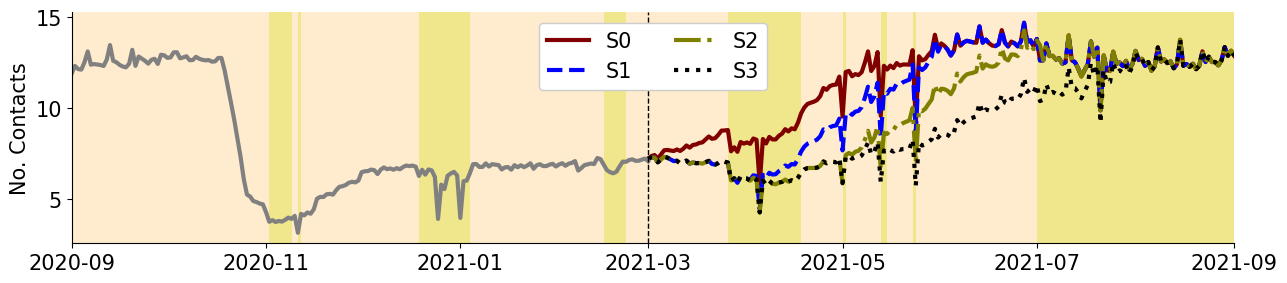

In [11]:
##############
## Settings ##
##############

#start_visualization = '2020-09-01'
#end_visualization = '2021-09-01'
start_scenarios = '2021-03-01'

scenario_colors = ['maroon', 'blue', 'olive', 'black']
scenario_linestyles=['-','--','-.',':']
legend_text=['S0', 'S1', 'S2', 'S3']
#scatter_size = 10
#alpha_scatter = 1

fig, ax = plt.subplots(figsize=(15,3))

###################
## Plot contacts ##
###################

for i in range(len(start_relaxations)):
    ax.plot(contacts[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
ax.legend(legend_text, loc=9, ncol=2, framealpha=1)
ax.plot(contacts_normal[:start_scenarios], color='gray')

########################
## Plot vertical line ##
########################

ax.axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_background, end_sim, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

###################
## Format figure ##
###################

ax.set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
ax.grid(False)
ax.set_ylabel('No. Contacts')

plt.savefig(f"four_projected_Nc_1mar2021.pdf", bbox_inches='tight')

## Time-dependent parameter functions used

Copy contents to the time dependent model parameters script.

In initialization function add the variable `start_relaxation` to the model parameters dictionary.

Switch of delta VOC in draw function.

In [ ]:
def policies_all_manuscript(self, t, states, param, l1, l2, eff_schools, eff_work, eff_rest, eff_home, k, mentality, start_relaxation):
    '''
    Function that returns the time-dependant social contact matrix Nc for all COVID waves.

    Input
    -----
    t : Timestamp
        simulation time
    states : xarray
        model states
    param : dict
        model parameter dictionary
    l1 : float
        Compliance parameter for social policies during first lockdown 2020 COVID-19 wave
    l2 : float
        Compliance parameter for social policies during second lockdown 2020 COVID-19 wave        
    eff_{location} : float
        "Effectivity" of contacts at {location}. Alternatively, degree correlation between Google mobility indicator and SARS-CoV-2 spread at {location}.
    k: float
        Parameter of the behavioral change model, linking number of infections to reduction in contacts.
        https://www.sciencedirect.com/science/article/pii/S1755436518301063 
    mentality: float

    Returns
    -------
    CM : np.array (9x9)
        Effective contact matrix (output of __call__ function)
    '''

    # Behavioral change model
    # Moving window of hospital in
    self.I.append(np.sum(states['H_in']))
    self.I = self.I[1:]
    I = np.mean(self.I)
    T=11e6
    mentality_behavioral = 1-(1-I/T)**k

    # Assumption eff_schools = eff_work
    eff_schools=eff_work

    t = pd.Timestamp(t.date())
    # Convert compliance l to dates
    l1_days = pd.Timedelta(l1, unit='D')
    l2_days = pd.Timedelta(l2, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-16') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
    t5 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
    t6 = pd.Timestamp('2020-09-01') # end of summer holidays
    t7 = pd.Timestamp('2020-09-21') # Opening universities

    # Define key dates of winter 2020-2021
    t8 = pd.Timestamp('2020-10-19') # lockdown (1)
    t9 = pd.Timestamp('2020-11-02') # lockdown (2)
    t10 = pd.Timestamp('2020-11-16') # schools re-open
    t11 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t12 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t13 = pd.Timestamp('2021-02-15') # Spring break starts
    t14 = pd.Timestamp('2021-02-21') # Spring break ends
    
    start = pd.Timestamp(start_relaxation)
    t15 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t16 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t17 = pd.Timestamp('2021-07-01') # Start of Summer holidays

    ################
    ## First wave ##
    ################

    if t <= t1:
        return self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1-mentality_behavioral, school=1)
    elif t1 < t <= t1 + l1_days:
        policy_old = self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1-mentality_behavioral, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t1, l1)
    elif t1 + l1_days < t <= t2:
        return self.__call__(t, eff_home=eff_home, eff_schools=eff_schools, eff_work=eff_work, eff_rest=eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t2 < t <= t3:
        l = (t3 - t2)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t2, l)            
    elif t3 < t <= t4:
        l = (t4 - t3)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality = 1-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t3, l)  
    elif t4 < t <= t5:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)                                          
    elif t5 < t <= t6:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    ######################      
    ## Winter 2020-2021 ##
    ######################

    elif t6 < t <= t7:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0.7)  
    elif t7 < t <= t8:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1) # Government proclaimed pandemic is over  
    elif t8  < t <= t8 + l2_days:
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t8, l2)
    elif t8 + l2_days < t <= t9:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t9 < t <= t10:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t10 < t <= t11:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1) 
    elif t11 < t <= t12:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t12 < t <= t13:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
    elif t13 < t <= t14:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)    

    if start_relaxation == '2021-03-01':
        if t14 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= t15:
            l = (t15 - start)/pd.Timedelta(days=1)
            r = (t15 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)  
        elif t15 < t <= t16:
            l = (t16 - t15)/pd.Timedelta(days=1)
            r1 = (t15 - start)/pd.Timedelta(days=62)
            r2 = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r1*(1-mentality)-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r2*(1-mentality)-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t15, l)  
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start+pd.Timedelta(days=62) - t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)  
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-04-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        elif start < t <= t16:
            l = (t16-start)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-05-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-06-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= t17:
            l = (t17-start)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t17 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t17)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t17, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

In [ ]:
def policies_all_spatial_manuscript(self, t, states, param, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, k, summer_rescaling_F, summer_rescaling_W, start_relaxation):
    '''
    Function that returns the time-dependant social contact matrix Nc for all COVID waves.

    Input
    -----
    t : Timestamp
        simulation time
    states : xarray
        model states
    param : dict
        model parameter dictionary
    l1 : float
        Compliance parameter for social policies during first lockdown 2020 COVID-19 wave
    l2 : float
        Compliance parameter for social policies during second lockdown 2020 COVID-19 wave        
    eff_{location} : float
        "Effectivity" of contacts at {location}. Alternatively, degree correlation between Google mobility indicator and SARS-CoV-2 spread at {location}.
    mentality : float
        Lockdown mentality multipier

    Returns
    -------
    CM : np.array (9x9)
        Effective contact matrix (output of __call__ function)
    '''

    # Assumption eff_schools = eff_work
    eff_schools=eff_work

    # Behavioral change model
    # Moving window of hospital in
    self.I.append(np.sum(states['H_in']))
    self.I = self.I[1:]
    I = np.mean(self.I)
    T=11e6
    mentality_behavioral = 1-(1-I/T)**k

    # Protection against dipping below zero
    if mentality_behavioral > mentality:
        mentality_behavioral = mentality

    t = pd.Timestamp(t.date())
    # Convert compliance l to dates
    l1_days = pd.Timedelta(l1, unit='D')
    l2_days = pd.Timedelta(l2, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-16') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
    t5 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
    t6 = pd.Timestamp('2020-09-01') # end of summer holidays
    t7 = pd.Timestamp('2020-09-21') # Opening universities

    # Define key dates of winter 2020-2021
    t8 = pd.Timestamp('2020-10-19') # lockdown (1)
    t9 = pd.Timestamp('2020-11-02') # lockdown (2)
    t10 = pd.Timestamp('2020-11-16') # schools re-open
    t11 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t12 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t13 = pd.Timestamp('2021-02-15') # Spring break starts
    t14 = pd.Timestamp('2021-02-21') # Spring break ends
    
    start = pd.Timestamp(start_relaxation)
    t15 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t16 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t17 = pd.Timestamp('2021-07-01') # Start of Summer holidays


    # Manual tweaking is unafortunately needed to make sure the second 2020 wave is correct
    # It is better to tweak the summer of 2020, if not, the summer of 2021 needs to be tweaked..

    if self.G == 11:
        idx_Hainaut = [6,]
        idx_Vlaams_Brabant = [1,]
        idx_Waals_Brabant = [2,]
        idx_F = [0, 1, 4, 5, 8]
        idx_Bxl = [3,]
        idx_W = [2, 6, 7, 9, 10]
        # Coefficients based on relative second wave peak height (as compared to NIS: 20001) 
        mentality_summer_2020_lockdown = np.array([1.78, 1,     # F
                                                2,              # W
                                                4.11,           # Bxl
                                                2.44, 2.44,     # original: 2.89, 2.44, # F
                                                4.44, 4,        # W
                                                1.5,            # original: 1.11, # F
                                                2.22, 2.67])    # W
        # Rescale Flanders and Wallonia/Bxl seperately based on two parameters
        mentality_summer_2020_lockdown[idx_F] *= summer_rescaling_F
        mentality_summer_2020_lockdown[idx_Bxl] *= summer_rescaling_W
        mentality_summer_2020_lockdown[idx_W] *= summer_rescaling_W

    elif self.G == 43:
        idx_Hainaut = [21, 22, 23, 24, 25, 26, 27,]
        idx_Vlaams_Brabant = [4,5]
        idx_Waals_Brabant = [6,]
        idx_F = [0, 1, 2,                          # Antwerpen
                4, 5,                              # Vlaams-Brabant
                7, 8, 9, 10, 11, 12, 13, 14,       # West-Vlaanderen
                15, 16, 17, 18, 19, 20,            # Oost-Vlaanderen
                32, 33, 34]                        # Limburg      
        idx_Bxl = [3,]                             # Brussel                    
        idx_W = [6,                                # Waals-Brabant
                21, 22, 23, 24, 25, 26, 27,        # Henegouwen
                28, 29, 30, 31,                    # Luik
                35, 36, 37, 38, 39,                # Luxemburg
                40, 41, 42]                        # Namen

        # Coefficients based on relative second wave peak height (as compared to NIS: 20001) 
        mentality_summer_2020_lockdown = np.ones(43)
        mentality_summer_2020_lockdown[0:3] = 1.78      # Antwerpen
        mentality_summer_2020_lockdown[4:6] = 1.00         # Vlaams-Brabant
        mentality_summer_2020_lockdown[6] = 2.00       # Waals-Brabant
        mentality_summer_2020_lockdown[3] = 4.11     # Brussel
        mentality_summer_2020_lockdown[7:15] = 2.44    # West-Vlaanderen
        mentality_summer_2020_lockdown[15:21] = 2.44   # Oost-Vlaanderen
        mentality_summer_2020_lockdown[21:28] = 4.44   # Henegouwen
        mentality_summer_2020_lockdown[28:32] = 4.00   # Luik
        mentality_summer_2020_lockdown[32:35] = 1.5   # Limburg
        mentality_summer_2020_lockdown[35:40] = 2.22  # Luxemburg
        mentality_summer_2020_lockdown[40:43] = 2.67   # Namen

        # Rescale Flanders and Wallonia/Bxl seperately based on two parameters
        mentality_summer_2020_lockdown[idx_F] *= summer_rescaling_F
        mentality_summer_2020_lockdown[idx_Bxl] *= summer_rescaling_W
        mentality_summer_2020_lockdown[idx_W] *= summer_rescaling_W

    ################
    ## First wave ##
    ################

    if t <= t1:
        return self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1-mentality_behavioral, school=1) 
    elif t1 < t <= t1 + l1_days:
        policy_old = self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1-mentality_behavioral, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t1, l1)
    elif t1 + l1_days < t <= t2:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t2 < t <= t3:
        l = (t3 - t2)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t2, l)            
    elif t3 < t <= t4:
        l = (t4 - t3)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t3, l)  
    elif t4 < t <= t5:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=tuple(mentality_summer_2020_lockdown), school=0)                                     
    elif t5 < t <= t6:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)      

    ######################      
    ## Winter 2020-2021 ##
    ######################

    elif t6 < t <= t7:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0.7)  
    elif t7 < t <= t8:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)  
    elif t8  < t <= t8 + l2_days:
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t8, l2)
    elif t8 + l2_days < t <= t9:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t9 < t <= t10:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t10 < t <= t11:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1) 
    elif t11 < t <= t12:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
    elif t12 < t <= t13:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
    elif t13 < t <= t14:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)    

    if start_relaxation == '2021-03-01':
        if t14 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= t15:
            l = (t15 - start)/pd.Timedelta(days=1)
            r = (t15 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)  
        elif t15 < t <= t16:
            l = (t16 - t15)/pd.Timedelta(days=1)
            r1 = (t15 - start)/pd.Timedelta(days=62)
            r2 = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r1*(1-mentality)-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r2*(1-mentality)-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t15, l)  
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start+pd.Timedelta(days=62) - t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)  
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-04-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
        elif start < t <= t16:
            l = (t16-start)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-05-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

    elif start_relaxation == '2021-06-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
        elif start < t <= t17:
            l = (t17-start)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality-mentality_behavioral, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t17 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t17)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality)-mentality_behavioral, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t17, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1-mentality_behavioral, school=0)

In [ ]:
def policies_all_work_only_manuscript(self, t, states, param, eff_work, l1, l2, mentality, k, summer_rescaling_F, summer_rescaling_W, start_relaxation):
        '''
        Function that returns the time-dependant social contact matrix of work contacts (Nc_work). 

        Input
        -----
        t : Timestamp
            simulation time
        states : xarray
            model states
        param : dict
            model parameter dictionary
        eff_work : float
            "Effectivity" of contacts at work. Alternatively, degree correlation between Google mobility indicator for work and SARS-CoV-2 spread at work.
        mentality : float
            Lockdown mentality multipier

        Returns
        -------
        CM : np.array
            Effective contact matrix (output of __call__ function)
        '''
        t = pd.Timestamp(t.date())

        # Behavioral change model
        # Moving window of hospital in
        self.I.append(np.sum(states['H_in']))
        self.I = self.I[1:]
        I = np.mean(self.I)
        T=11e6
        mentality_behavioral = 1-(1-I/T)**k

        # Protection against dipping below zero
        if mentality_behavioral > mentality:
            mentality_behavioral = mentality

        # Convert compliance l to dates
        l1_days = pd.Timedelta(l1, unit='D')
        l2_days = pd.Timedelta(l2, unit='D')

        if self.G == 11:
            idx_Hainaut = [6,]
            idx_Vlaams_Brabant = [1,]
            idx_Waals_Brabant = [2,]
            idx_F = [0, 1, 4, 5, 8]
            idx_Bxl = [3,]
            idx_W = [2, 6, 7, 9, 10]
            # Coefficients based on relative second wave peak height (as compared to NIS: 20001) 
            mentality_summer_2020_lockdown = np.array([1.78, 1,     # F
                                                    2,              # W
                                                    4.11,           # Bxl
                                                    2.44, 2.44,     # original: 2.89, 2.44, # F
                                                    4.44, 4,        # W
                                                    1.5,            # original: 1.11, # F
                                                    2.22, 2.67])    # W

            mentality_summer_2020_lockdown[idx_F] *= summer_rescaling_F
            mentality_summer_2020_lockdown[idx_Bxl] *= summer_rescaling_W
            mentality_summer_2020_lockdown[idx_W] *= summer_rescaling_W

        elif self.G == 43:
            idx_Hainaut = [21, 22, 23, 24, 25, 26, 27,]
            idx_Vlaams_Brabant = [4,5]
            idx_Waals_Brabant = [6,]
            idx_F = [0, 1, 2,                          # Antwerpen
                    4, 5,                              # Vlaams-Brabant
                    7, 8, 9, 10, 11, 12, 13, 14,       # West-Vlaanderen
                    15, 16, 17, 18, 19, 20,            # Oost-Vlaanderen
                    32, 33, 34]                        # Limburg      
            idx_Bxl = [3,]                             # Brussel                    
            idx_W = [6,                                # Waals-Brabant
                    21, 22, 23, 24, 25, 26, 27,        # Henegouwen
                    28, 29, 30, 31,                    # Luik
                    35, 36, 37, 38, 39,                # Luxemburg
                    40, 41, 42]                        # Namen

            # Coefficients based on relative second wave peak height (as compared to NIS: 20001) 
            mentality_summer_2020_lockdown = np.ones(43)
            mentality_summer_2020_lockdown[0:3] = 1.78      # Antwerpen
            mentality_summer_2020_lockdown[4:6] = 1.00         # Vlaams-Brabant
            mentality_summer_2020_lockdown[6] = 2.00       # Waals-Brabant
            mentality_summer_2020_lockdown[3] = 4.11     # Brussel
            mentality_summer_2020_lockdown[7:15] = 2.44    # West-Vlaanderen
            mentality_summer_2020_lockdown[15:21] = 2.44   # Oost-Vlaanderen
            mentality_summer_2020_lockdown[21:28] = 4.44   # Henegouwen
            mentality_summer_2020_lockdown[28:32] = 4.00   # Luik
            mentality_summer_2020_lockdown[32:35] = 1.5   # Limburg
            mentality_summer_2020_lockdown[35:40] = 2.22  # Luxemburg
            mentality_summer_2020_lockdown[40:43] = 2.67   # Namen

            # Rescale Flanders and Wallonia/Bxl seperately based on two parameters
            mentality_summer_2020_lockdown[idx_F] *= summer_rescaling_F
            mentality_summer_2020_lockdown[idx_Bxl] *= summer_rescaling_W
            mentality_summer_2020_lockdown[idx_W] *= summer_rescaling_W

        ################
        ## First wave ##
        ################

        # Define key dates 
        t1 = pd.Timestamp('2020-03-16') # start of lockdown
        t2 = pd.Timestamp('2020-05-15') # start of relaxation
        t3 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
        t4 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
        t5 = pd.Timestamp('2020-09-21') # Universities open
        t6 = pd.Timestamp('2020-10-19') # start of lockdown
        t7 = pd.Timestamp('2020-11-16') # schools re-open
        start = pd.Timestamp(start_relaxation)

        # Define number of contacts
        if t <= t1:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=1, eff_rest=0, mentality=1-mentality_behavioral, school=0) 
        elif t1 < t <= t1 + l1_days:
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=1, eff_rest=0, mentality=1-mentality_behavioral, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0) 
            return self.ramp_fun(policy_old, policy_new, t, t1, l1)
        elif t1 + l1_days < t <= t2:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0) 
        elif t2 < t <= t3:
            l = (t3 - t2)/pd.Timedelta(days=1)
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1-mentality_behavioral, school=0) 
            return self.ramp_fun(policy_old, policy_new, t, t2, l)
        elif t3 < t <= t4:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=tuple(mentality_summer_2020_lockdown), school=0)
        elif t4 < t <= t5:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1-mentality_behavioral, school=0)       

        ######################
        ## Winter 2020-2021 ##
        ######################

        elif t5 < t <= t6:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)
        elif t6  < t <= t6 + l2_days:
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t6, l2)
        elif t6 + l2_days < t <= t7:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0) 
        elif t7 < t <= start:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality-mentality_behavioral, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1-mentality_behavioral, school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1-mentality_behavioral, school=0)

